# Week 5: Machine Learning 2

There are innumerable machine learning models (and algorithms for fitting them to data) out there, and each one has something special about it that makes it suitable to a specific type of problem. To apply machine learning and get some initial results is fairly straight forward. Getting under the hood, however, requires a bit of work. This week we will look into how Decision Trees and PCA works. In the exercises today you will:

* Implement a standard decision tree mechanism
* Use PCA to visualize clusters in your data

[**Questions**](https://github.com/ulfaslak/computational_analysis_of_big_data_2018_fall/issues) **/** [**Feedback**](http://ulfaslak.com/vent)

## Exercises

**Get started**: Load the data you used last week to classify hero/villainness. It should consist of two arrays, one of dimensions ($N_{characters}$, $N_{teams}$) which is your feature matrix that has the team alliances of each character as a row vector of ones and zeros, and another of dimensions ($N_{characters}$, ) which is your target array that gives whether a character is a hero (1) or a villain (0). You can either load the data or copy/paste the code that generates it.

*Hint: If you had trouble with the data, use mine, called `affiliations.csv` in the `data` folder. You can load it as a `pandas.DataFrame`, with `pd.read_csv('data_team_alliances.csv', index_col=0)`. The rightmost column is the target array. Do not include this in PCA (think about why)!.*

### Part 1: Decision trees

This does not exactly look right. Not sure what the problem could be, but I'm guessing you are not computing the average weighted entropy right.

If you look in my slides from yesterday I give an example of how to compute the split entropy on page 18-23. The idea is that:

The question you ask to your data ("do you lay eggs" or "are you affiliated with the X-Men alliance?") splits the data into to two subsets, one that answers yes to the question and one that answers no.
In each of these subsets you can then compute the entropy of distribution of target values. In other words, if, say, in your first subset (the ones that answered "yes" and this were all affiliated with X-Men), there are 90% heroes, 3% villains and 7% ambiguous, the entropy of that distribution would be shannon_entropy([0.9, 0.03, 0.07]).
You compute the target entropy of both your subsets.
The weighted average entropy you can then compute by averaging the two numbers, with the twist that each term has to be weighted by how large the subset it estimates the entropy of is. Example: If the X-Men affiliated subset is 30 large and the non-X-Men subset is 1000, then the weighted average is:

In this exercise you will implement the decision making algorithm of a decision tree classifier, step by step.

>**Ex. 5.1.1**: Read about [Shannon entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory).
1. What is it? How is it defined mathematically (write out the formula in LateX formatting)?
2. Write a function that computes the Shannon-entropy of a probability vector. Compute the Shannon entropy of `p=[0.4, 0.6]`.

In [29]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
from collections import Counter

>**Ex. 5.1.2**: Split your data into two subsets. One where characters are affiliated with X-men and one where they are not.
1. What is the entropy of target labels in each subset?
2. What is the weighted average entropy of the split?
3. Write a function that computes the weighted average entropy of a split, given the data and team (name or id) on which to split the data.
4. Plot the distribution of split entropy for all features. Comment on the result. My figure looks [like this](http://ulfaslak.com/computational_analysis_of_big_data/exer_figures/example_6.2.2.4.png).

In [23]:
import pandas as pd
marvel = pd.read_csv("marvel.csv",index_col=0)
marvel_features = marvel.iloc[:,:-1]
marvel_target = marvel.faction

In [24]:
def shannon(p):
    """Computes the Shannon Entropy of a given list of probabilities"""
    return -1.0*sum([x*np.log2(x) for x in p])

def compute_avg_ent_feature(pdata, feature):
    """DOCSTRING"""
    #solves for entropy of a split
    def compute_entropy(sdata):
        size = 1.0*len(sdata)
        count = Counter(sdata.faction)
        dist = [1.0 * x/size for x in count.values()]
        return size,shannon(dist)
    
    #split that contains this feature
    side_1 = pdata[pdata[feature] == 1]
    
    #split that does not contain this feature
    side_2 = pdata[pdata[feature] == 0]
    
    #compute the entropy of both brances and store their sizes
    s1, ent_1 = compute_entropy(side_1)
    s2, ent_2 = compute_entropy(side_2)
    
    #compute the entropy of the main and the size
    p1, entropy_before = compute_entropy(pdata)
    
    #weight_1*entropy_1 + weight_2*entropy_2 
    entropy_after = ((s1/p1)*ent_1 + (s2/p1)*ent_2)
    
    return entropy_after



In [25]:
compute_avg_ent_feature(marvel,"X-Men")

1.3303827580272767

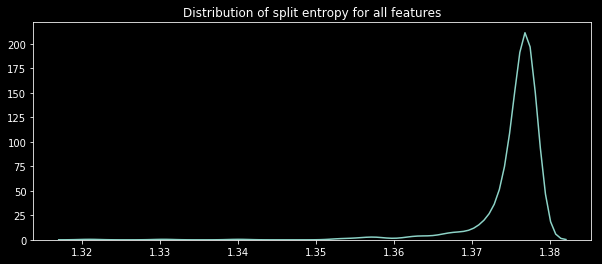

In [30]:
# Plot the distribution of split entropy for all features
def plot_entropy(data):
    all_entropy = []
    for progress,column in enumerate(data):
        if column != 'faction':
            all_entropy.append(compute_avg_ent_feature(data,column))
            # print("Computing average of split entropy...[%d / %d] \r" % (progress+1,len(marvel.columns)-1),end='\r')

    plt.figure(figsize=(10,4))
    plt.title("Distribution of split entropy for all features")
    sns.kdeplot(all_entropy)

    plt.show()
plot_entropy(marvel)

### >**Ex. 5.1.3**: Print the maximum entropy path of a decision tree.
>
>1. Implement the following pseudocode and print the output:<br><br>
>Step 1. Find `team` that gives lowest split entropy for `data`. Print `team`.<br>
>Step 2. Split `data` on `team`, to produce `data0` and `data1`. Print the entropy of each, as well as their weighted avg. entropy.<br>
>Step 3. Overwrite the `data` variable with either `data0` or `data1`, depending on which has the highest entropy.<br>
>Step 4. Stop if there are less than 5 datapoints in `data`. Otherwise start over from 1.<br><br>
>My output looks [like this](http://ulfaslak.com/computational_analysis_of_big_data/exer_figures/example_6.2.3.1.png) for the first five splits.<br><br>
>
>2. Comment on decision path your code takes: How splits are there? Do you notice anything interesting about the final splits? Why do we choose to stop splitting before `data` get smaller than 5?

>3. Train a `sklearn.tree.DecisionTreeClassifier` classifier on the dataset. Initiate the classifier with `criterion='entropy'`. What are the most important features of this classifier? How does this line up with the order of the order of splits you just printed (a comment is fine)?

In [32]:
def lowest_split_entropy(data):
    lowest = 2 #start with any integer. The highest entropy was about ~1.4
    team_name = ""
    for team in data:
        if team != 'faction':
            team_entropy = compute_avg_ent_feature(data,team)
            if team_entropy < lowest:
                lowest = team_entropy
                team_name = team
    return team_name


def max_entropy_path(data):
    path = 0
    while data.shape[0] > 6: #putting this to 5 = infinite loop on A-Force team
        lowest_team = lowest_split_entropy(data)
        headline = "Split %d: %s" % (path,lowest_team)
        print (headline + "\n" + "="*len(headline))

        s1,ent_1 = compute_entropy(data[data[lowest_team]==1])
        s2,ent_2 = compute_entropy(data[data[lowest_team]==0])

        print ("   data0:\n      size: %d\n      entropy: %.4f\n" % (s1, ent_1))
        print ("   data1:\n      size: %d\n      entropy: %.4f" % (s2, ent_2))
        print ("\n-->   average entropy: %.4f\n\n" % compute_avg_ent_feature(data,lowest_team))

        if ent_1 > ent_2:
            data = data[data[lowest_team]==1]
        else:
            data = data[data[lowest_team]==0]
        path += 1
    return path
path = max_entropy_path(marvel)
print ("Max entropy path: %d" % path)

Split 0: Avengers
   data0:
      size: 95
      entropy: 0.6150

   data1:
      size: 1190
      entropy: 1.3773

-->   average entropy: 1.3209


Split 1: X-Men
   data0:
      size: 98
      entropy: 1.0164

   data1:
      size: 1092
      entropy: 1.3528

-->   average entropy: 1.3251


Split 2: Masters of Evil
   data0:
      size: 70
      entropy: 0.6587

   data1:
      size: 1022
      entropy: 1.3575

-->   average entropy: 1.3127


Split 3: Maggia
   data0:
      size: 25
      entropy: -0.0000

   data1:
      size: 997
      entropy: 1.3658

-->   average entropy: 1.3324


Split 4: X-Men-In-Training
   data0:
      size: 19
      entropy: -0.0000

   data1:
      size: 978
      entropy: 1.3673

-->   average entropy: 1.3413


Split 5: New Warriors
   data0:
      size: 34
      entropy: 0.9112

   data1:
      size: 944
      entropy: 1.3588

-->   average entropy: 1.3433




KeyboardInterrupt: 

In [19]:
import sklearn.tree
tree_classifier = sklearn.tree.DecisionTreeClassifier(criterion='entropy')
tree_classifier.fit(features,target)

x = tree_classifier.apply(features)
print x

[147 105 160 119 110 179  71 179 101 136 160 160 160  70 105 179 179 165
 150 160  67  69 147 179 149 100 179 113 105 160 179 136 160 110 160 105
 133 167  64 179 136 150 153 179 116  60  88 179  58 147  97 179  57 113
 179 147 160 179 138 138 105 179 120  59  62 160 160 179 116 160 160 179
  63 166 179 138  61 149 160  65 105  72  98  66 179 149 138 100 179 150
 167  55 179  74 160  68 160 179  86  88  74 179 101  52  95 179 149 179
 131 179  96 179 150 167 160 179 179 179  50  50  56 125  50  50 125  50
  50  52  50 125  50  50  52 125  50  50  50  50  50 172  50  99  50  50
  50  50 154  50  50  50  50  50 106  50  50  50  50 154  50  50 154 125
  50  94  50  50  50  50  50  50  50  50 154 107  53 107  50  50  50  50
  77  50  50  50  50  50 121 121  50  50  50  50 154 145  50  50  52  57
  50 121 154  50  75  50  50 121 154  50  50 121 154 154 145  50  50  50
 154 144  50  50  50 142  52 175  50  50 121  50  50  50 121  50  50  50
  50  50  50  53  50  83 117 181  80 182 127 137  8

### Part 2 (extra): Dimensionality reduction (PCA and ICA)

The point of this exercise is to learn how to visualize high-dimensional data, and get a feeling of how your Marvel data looks when projected to a plane.

>**Ex. 5.2.1**: Apply a PCA transformation to your data. If `X` is your feature matrix, PCA works like:

>        pca = sklearn.decomposition.PCA()
>        pca.fit(X)
>        X_pca = pca.transform(X)

>1. What is the dimensionality of `X_pca` compared to `X`? What happened to `X` when you transformed it?
2. Plot the first two components/columns of the transformed data and color the points by their class label. My plot looks [like this](http://ulfaslak.com/computational_analysis_of_big_data/exer_figures/example_6.1.1.2.png). Comment on the result. What would plotting two other components against each other show you?
3. Plot the explained variance ratio of each component. What does this tell you about the dataset? My plot looks [like this](http://ulfaslak.com/computational_analysis_of_big_data/exer_figures/example_6.1.1.3.png).

>*Hint for 2: `plt.scatter` takes an argument `color` which must receive either a string such as `red` or `blue`, or a list of rgb values or strings such as `['red', 'blue', 'blue', ...]`.*

In [33]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA()

pca.fit(marvel_features)
X_pca = pca.transform(marvel_features)

In [35]:
print (X_pca.shape, marvel_features.shape)

(1285, 647) (1285, 647)


>**Ex. 5.2.2**: In a similar fashion, apply an ICA transformation to your data.

>1. Read about [ICA](https://en.wikipedia.org/wiki/Independent_component_analysis).
2. Plot the the transformed data on a number of different ICA components. Color the points by their class label. Comment on the differences between the result of ICA and PCA.